### Library Imports

In [2]:
#for data pulling
import requests
import pickle
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#for econometrics tests
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from pandas.tseries.offsets import BDay



## Data loading

EIA API key is needed. Please run first dataproc notebook to craft sentiment index data.


Loaded data:
- *data_week and data_daily*: EIA information on WTI spot price and reserve leves
- *index*: processed sentiment index (crafted in dataproc notebook), crafted from CFTC COT data
- *ecou_idx*: FRED economic policy uncertainty index
- *ovx_data*: OVX index, loaded from FRED data



In [3]:
API_KEY = str(input('Insert EIA API key'))

In [4]:
url = "https://api.eia.gov/v2/petroleum/sum/sndw/data/"
params = {
    "frequency": "weekly",
    "data[0]": "value",
    "facets[series][]": "WTTSTUS1",
    "sort[0][column]": "period",
    "sort[0][direction]": "desc",
    "offset": 0,
    "length": 5000,
    "api_key": API_KEY,
}

r = requests.get(url, params=params, timeout=30)
r.raise_for_status()

rows = r.json()["response"]["data"]
df = pd.DataFrame(rows)
df["period"] = pd.to_datetime(df["period"])
df = df.sort_values("period")

url_spot = "https://api.eia.gov/v2/petroleum/pri/spt/data/"

def eia_get_all_pages(url, params, page_size=5000):
    all_rows = []
    offset = 0

    while True:
        p = params.copy()
        p["offset"] = offset
        p["length"] = page_size

        r = requests.get(url, params=p, timeout=30)
        r.raise_for_status()

        chunk = r.json()["response"]["data"]
        if not chunk:
            break

        all_rows.append(pd.DataFrame(chunk))

        # last page
        if len(chunk) < page_size:
            break

        offset += page_size

    out = pd.concat(all_rows, ignore_index=True)
    out["period"] = pd.to_datetime(out["period"])
    out = out.sort_values("period").set_index("period")
    out["spot"] = out["value"].astype(float)
    return out[["spot"]]


params_spot_day = {
    "frequency": "daily",
    "data[0]": "value",
    "facets[series][]": "RWTC",
    "start": "1990-01-05",            
    "sort[0][column]": "period",
    "sort[0][direction]": "asc",
    "api_key": API_KEY,
}

dfs_d = eia_get_all_pages(url_spot, params_spot_day, page_size=5000)

In [5]:
data_week = pd.DataFrame(df['period'])
data_week["reserves"] = df["value"].astype(float)
data_week.set_index("period", inplace=True)

data_day = pd.DataFrame( dfs_d["spot"].astype(float))

data_week = data_week.join(data_day[["spot"]], how="left")



In [6]:
EIA_WPSR_SCHEDULE_URL = "https://www.eia.gov/petroleum/supply/weekly/schedule.php"

# Function adapted to our needs #######################################################################################################
def build_release_date_index(week_end_idx: pd.DatetimeIndex) -> pd.Series:
    """
    week_end_idx: EIA weekly 'period' index (week ending dates, typically Fridays)

    Returns: release_date (date-only), using:
      - default rule: next Wednesday
      - override: EIA holiday exceptions table (week ending -> release date)
    """
    week_end_idx = pd.to_datetime(week_end_idx).normalize()

    # --- default mapping: next Wednesday (Wed=2; Mon=0,...)
    wd = week_end_idx.weekday
    delta = (2 - wd) % 7
    delta = pd.Series(delta, index=week_end_idx).replace(0, 7)  # force "next" Wed
    release_date = pd.Series(week_end_idx + pd.to_timedelta(delta, unit="D"),
                             index=week_end_idx, name="release_date")

    # --- override mapping using EIA exceptions table (holiday weeks)
    try:
        tables = pd.read_html(EIA_WPSR_SCHEDULE_URL)
        exc = None
        for t in tables:
            cols = [str(c).lower() for c in t.columns]
            if any("week" in c and "end" in c for c in cols) and any("release" in c and "date" in c for c in cols):
                exc = t.copy()
                break

        if exc is not None:
            exc.columns = [str(c).strip().lower() for c in exc.columns]
            week_col = next(c for c in exc.columns if "week" in c and "end" in c)
            rel_col = next(c for c in exc.columns if "release" in c and "date" in c)

            exc = exc[[week_col, rel_col]].rename(columns={week_col: "week_end", rel_col: "release_date"})
            exc["week_end"] = pd.to_datetime(exc["week_end"], errors="coerce").dt.normalize()
            exc["release_date"] = pd.to_datetime(exc["release_date"], errors="coerce").dt.normalize()
            exc = exc.dropna().drop_duplicates()

            exc_map = exc.set_index("week_end")["release_date"]
            common = release_date.index.intersection(exc_map.index)
            release_date.loc[common] = exc_map.loc[common].values
    except Exception:
        pass  # if scraping fails, keep default mapping

    return release_date
#######################################################################################################################################

data_week = data_week.sort_index()
data_week.index = pd.to_datetime(data_week.index).normalize()
data_week.index.name = "week_end"

# Your level is already MBBL, so no /1000. Create weekly change now if you need it.
data_week["d_reserves"] = data_week["reserves"].diff()

# Build reporting/release dates
release_date = build_release_date_index(data_week.index)

# Put the weekly report "on the reporting date"
data_report = data_week.copy()
data_report["week_end"] = data_report.index
data_report["release_date"] = release_date.values

# Index on reporting date (this is your event-study anchor for daily windows)
data_report = data_report.set_index("release_date").sort_index()

# Safety check (should be 1 report per release date)
assert data_report.index.is_unique, "Non-unique release_date index: check mapping."
#----------------------------------------------------------------------------------------------------------------------------------------
spot_day = dfs_d[["spot"]].copy()
spot_day.index = pd.to_datetime(spot_day.index).normalize()
spot_day = spot_day.sort_index()
rep = data_report.copy()
rep.index = pd.to_datetime(rep.index).normalize()
rep = rep.sort_index()
rep_cols = [c for c in ["reserves", "d_reserves", "week_end"] if c in rep.columns]
rep = rep[rep_cols]
daily_joined = spot_day.join(rep, how="left")

daily_joined.head(10)


,spot,reserves,d_reserves,week_end
period,,,,
1990-01-05,23.07,NaN,NaN,NaT
1990-01-08,21.64,NaN,NaN,NaT
1990-01-09,22.25,NaN,NaN,NaT
1990-01-10,22.90,1584183.0,NaN,1990-01-05
1990-01-11,23.15,NaN,NaN,NaT
1990-01-12,23.17,NaN,NaN,NaT
1990-01-15,22.36,NaN,NaN,NaT
1990-01-16,22.61,NaN,NaN,NaT
1990-01-17,22.11,1593418.0,9235.0,1990-01-12


In [7]:
series_id = "USEPUINDXD" 
url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"

ecou_idx = pd.read_csv(url)
ecou_idx['period'] = pd.to_datetime(ecou_idx['observation_date'])
ecou_idx = ecou_idx.drop(columns='observation_date')
ecou_idx.set_index('period', inplace=True)


In [8]:
series_id = "OVXCLS"
url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}"

ovxData = pd.read_csv(url)
ovxData['period'] = pd.to_datetime(ovxData['observation_date'])
ovxData = ovxData.drop(columns='observation_date')
ovxData.set_index('period', inplace=True)

In [10]:
index = pd.read_pickle('sentimentIndex.pkl')

In [11]:
data_report = data_report.join(ecou_idx, how='left')
data_report = data_report.join(ovxData, how='left')
data_report = data_report.join(pd.DataFrame(index['Sentiment_Index']), how='left')

## Data Analysis

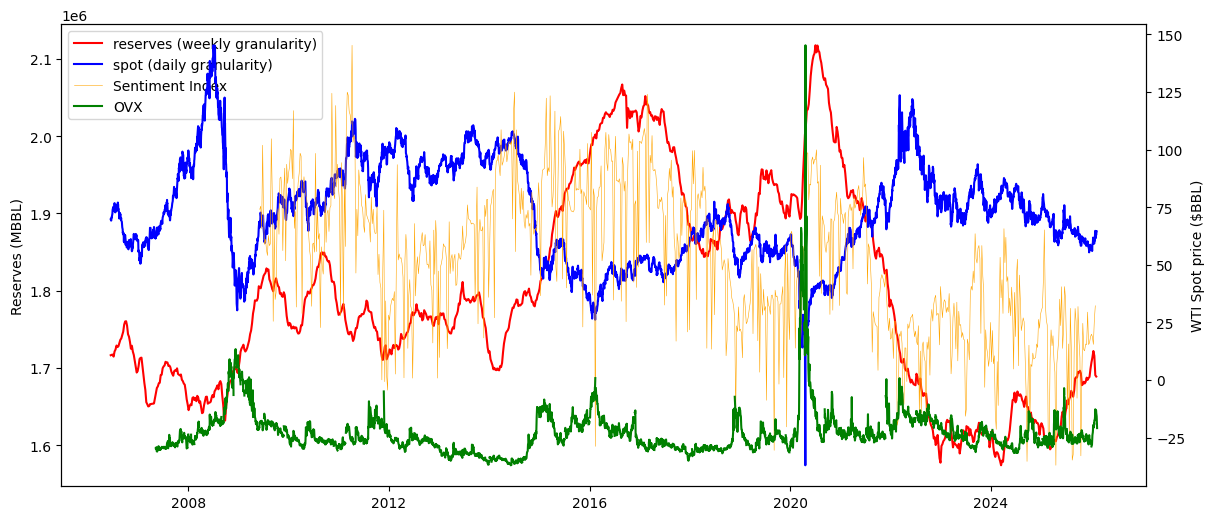

In [12]:
indexinit= index.index[0]

fig, ax1 = plt.subplots(figsize=(14, 6))

l1, = ax1.plot(data_week.loc[indexinit:].index, data_week.loc[indexinit:]["reserves"].to_numpy(), color="red", label="reserves (weekly granularity)")
ax1.set_ylabel("Reserves (MBBL)")

ax3 = ax1.twinx()
l3, = ax3.plot(data_day.loc[indexinit:].index, data_day.loc[indexinit:]["spot"].to_numpy(), color="blue", label="spot (daily granularity)")
ax3.set_ylabel("WTI Spot price ($BBL)")

ax5 = ax1.twinx()
l5, = ax5.plot(index.index, index["Sentiment_Index"].to_numpy(), linewidth=0.4,color="Orange", label="Sentiment Index")

ax6 = ax1.twinx()
l6, = ax6.plot(ovxData.index, ovxData["OVXCLS"].to_numpy(), color="green", label="OVX")

for ax in (ax5, ax6):
    ax.get_yaxis().set_visible(False)        # hides ticks + tick labels
    ax.spines["right"].set_visible(False)    # hides the right spine line
    ax.set_frame_on(False)                   # optional: removes axis frame


ax1.legend(handles=[l1, l3, l5, l6], loc="upper left")
plt.show()



We prepare for some econometrics analysis.

Peak in raw data correlation, we expect strong as inventory tends to decay and rise 

In [13]:
data_week['dlog_spot'] = np.log(data_week['spot']).diff()
data_week['d_reserves'] = data_week['reserves'].diff()
data = data_week[['dlog_spot','d_reserves']].dropna()

,lb_stat,lb_pvalue
1,160.024545,1.117598e-36
2,243.492985,1.337119e-53
3,287.343399,5.455292e-62
4,337.106976,1.065264e-71
5,381.007684,3.671699e-80
...,...,...
100,1352.376435,1.807223e-218
101,1357.225246,7.045364e-219
102,1358.587825,1.378361e-218
103,1371.843904,1.089222e-220


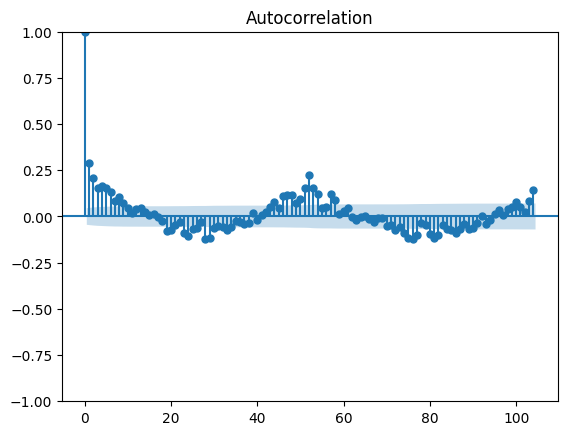

In [14]:
lag = 104 #2-year to see cyclicality
acf_input = data_week['d_reserves'].dropna()
# ACF plot
plot_acf(acf_input, lags=lag)
result = acorr_ljungbox(acf_input, lags=lag)
display(result)

plt.show()

Seasonality is important to take into consideration for our seasonal terms for future reserves expectations, and as this function shows, a yearly sinuisoidal seasonality component is sensible to the aucorrelation factors in the data.

In [15]:
for c in data.columns:
    p = adfuller(data[c])[1]
    print(c)
    if p < 0.01:
        print(c, "ADF p-value:", p, "- stationarity can be assumed")
    else:
        print(c, "ADF p-value:", p, "- stationarity can NOT be assumed")

dlog_spot
dlog_spot ADF p-value: 0.0 - stationarity can be assumed
d_reserves
d_reserves ADF p-value: 7.760747645168495e-23 - stationarity can be assumed


In [16]:
model = VAR(data)
lag_sel = model.select_order(12)
p = lag_sel.selected_orders['aic']
res = model.fit(p)
gc = res.test_causality(causing='d_reserves', caused='dlog_spot', kind='f')
print(gc.summary())


Granger causality F-test. H_0: d_reserves does not Granger-cause dlog_spot. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value          df        
---------------------------------------------------------
         1.595          2.217   0.158 (5, np.int64(3430))
---------------------------------------------------------


c:\Users\ericb\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


## Expectation setting:

Kalman filter implementation

Data prep for feature vectors of Kalman

In [17]:
def tvp_kf_with_explain_h(y_level: pd.Series, X: pd.DataFrame, h: int, q_vec, r=None, P0=1e4):

    L = y_level.astype(float).copy()
    X = X.astype(float).copy()

    L = L.loc[X.index].sort_index()
    X = X.loc[L.index].sort_index()

    idx = L.index
    Lv = L.values
    Xm = X.values
    T, k = Xm.shape

    q_vec = np.asarray(q_vec, dtype=float)
    if r is None:
        r = float(np.nanvar(pd.Series(Lv, index=idx).diff(h).dropna().values))
        if not np.isfinite(r) or r <= 0:
            r = 1.0

    Q = np.diag(q_vec)
    R = float(r)

    beta = np.zeros(k)
    P = P0 * np.eye(k)

    exp_d_h = np.full(T, np.nan)
    beta_used = np.full((T, k), np.nan)
    contrib = np.full((T, k), np.nan)

    for t in range(T):
        j = t - h
        if j >= 0:
            x_obs = Xm[j]
            if np.isfinite(x_obs).all() and np.isfinite(Lv[t]) and np.isfinite(Lv[j]):
                y_obs = Lv[t] - Lv[j]        
                P_pred = P + Q
                y_pred = x_obs @ beta
                v = y_obs - y_pred
                S = x_obs @ P_pred @ x_obs.T + R
                K = (P_pred @ x_obs.T) / S
                beta = beta + K * v
                P = P_pred - np.outer(K, x_obs) @ P_pred
        if t + h < T:
            x = Xm[t]
            if np.isfinite(x).all():
                beta_used[t] = beta
                exp_d_h[t] = x @ beta
                contrib[t] = x * beta

    exp_d_h = pd.Series(exp_d_h, index=idx, name=f"exp_d_reserves_h{h}")
    beta_used = pd.DataFrame(beta_used, index=idx, columns=X.columns)
    contrib = pd.DataFrame(contrib, index=idx, columns=X.columns)
    return exp_d_h, beta_used, contrib



In [30]:
df = data_report.sort_index().copy()

L = df["reserves"].astype(float)
y_week = L.diff()

t = np.arange(len(df), dtype=float)
X = pd.DataFrame(index=df.index)
X["const"] = 1.0
X["cos1"]  = np.cos(2*np.pi*t/52.0)
X["lag1"]  = y_week.shift(1)

#X["sentiment"] = df["Sentiment_Index"].shift(1)

# OVX: Tuesday close (release day - 1 business day)
ovx = ovxData["OVXCLS"].astype(float).copy()
ovx.index = pd.to_datetime(ovx.index).normalize()
X["ovx"] = pd.Series(
    [ovx.loc[:(d - BDay(1))].iloc[-1] if (ovx.index <= (d - BDay(1))).any() else np.nan for d in X.index],
    index=X.index
)

# EPU: USEPUINDXD (as-of release day - 1 business day), economic uncertainty index
epu = ecou_idx["USEPUINDXD"].astype(float).copy()
epu.index = pd.to_datetime(epu.index).normalize()
X["epu"] = pd.Series(
    [epu.loc[:(d - BDay(1))].iloc[-1] if (epu.index <= (d - BDay(1))).any() else np.nan for d in X.index],
    index=X.index
)

q_vec = []
for c in X.columns:
    if c in ["const", "cos1", "sin1"]:
        q_vec.append(1e-10)
    elif c.startswith("lag"):
        q_vec.append(1e-6)
    else:
        q_vec.append(1e-7)


h = 8

y4 = (L - L.shift(h)).dropna()
r_train = float(y4.iloc[:156].var())  # only first three years, to avoid look-ahead bias

exp_d4, beta_used4, contrib4 = tvp_kf_with_explain_h(L, X, h=h, q_vec=q_vec, r=r_train)
exp_L4 = (L + exp_d4).rename("exp_reserves_level_tplus4")


The filter seems to be very efficient at computing the changes in reserve levels, as we can see in the graph:

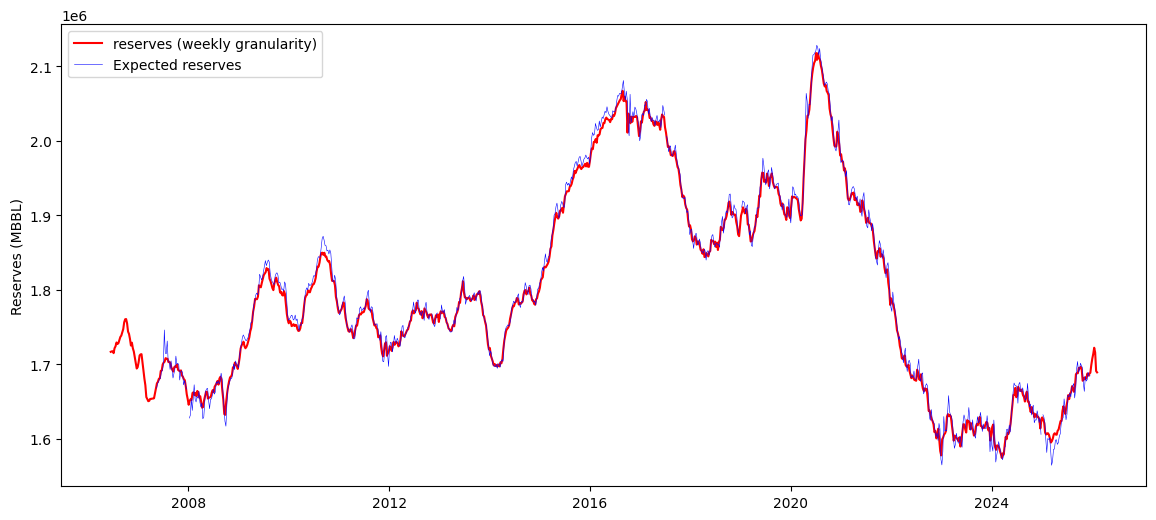

In [31]:
fig, ax1 = plt.subplots(figsize=(14, 6))

l1, = ax1.plot(data_week.loc[indexinit:].index, data_week.loc[indexinit:]["reserves"].to_numpy(), color="red", label="reserves (weekly granularity)")
ax1.set_ylabel("Reserves (MBBL)")


l2, = ax1.plot(pd.DataFrame(exp_L4).loc[indexinit:].index, pd.DataFrame(exp_L4).loc[indexinit:]["exp_reserves_level_tplus4"].to_numpy(), color="blue", linewidth=0.4, label="Expected reserves")
ax1.set_ylabel("Reserves (MBBL)")

ax1.legend(handles=[l1, l2], loc="upper left")
plt.show()



Surprisingly enough, and given the proven strong seasonality of the data, the cosine meant to capture this become not relevant in the preductions. We also saw that the time-series was autocorrelated, and therefore we see it reflected that the most important, but it is also insightful to see that OVX and Economic uncertainty have a very much non-negligible effect in predicting changes in the reserves.

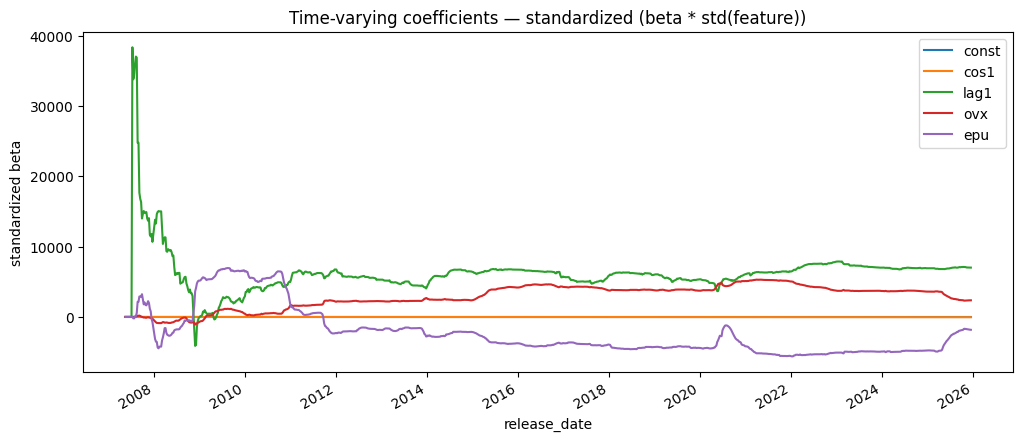

In [32]:
B = beta_used4.dropna()
Xs = X.loc[B.index].dropna()

std = Xs.std()
B_std = B * std

ax = B_std.plot(figsize=(12,5))
ax.set_title("Time-varying coefficients — standardized (beta * std(feature))")
ax.set_ylabel("standardized beta")
plt.show()

This can be powerful when simulating scenarios in the future that impact those variables and therefore reserves.